In [2]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_58430/884013642.py:20: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [3]:
def contract_to_unisphere(
    x: torch.Tensor,
    ord: float = 2,
    eps: float = 1e-6,
    derivative: bool = False,
    cdf_lb: float = 0.1,
    num_bins: int = 1000,
):  
    x_pdf, x_pos = torch.histogram(x[:, 0].cpu(), bins=num_bins)
    y_pdf, y_pos = torch.histogram(x[:, 1].cpu(), bins=num_bins)
    z_pdf, z_pos = torch.histogram(x[:, 2].cpu(), bins=num_bins)
    x_cdf, x_pos = torch.cumsum(x_pdf, dim=0) / x.shape[0], x_pos[:-1]
    y_cdf, y_pos = torch.cumsum(y_pdf, dim=0) / x.shape[0], y_pos[:-1]
    z_cdf, z_pos = torch.cumsum(z_pdf, dim=0) / x.shape[0], z_pos[:-1]

    aabb = torch.tensor([
        x_pos[x_cdf > cdf_lb].min(),
        y_pos[y_cdf > cdf_lb].min(),
        z_pos[z_cdf > cdf_lb].min(),
        x_pos[x_cdf > 1 - cdf_lb].min(),
        y_pos[y_cdf > 1 - cdf_lb].min(),
        z_pos[z_cdf > 1 - cdf_lb].min(),
    ], device=x.device)
    aabb_min, aabb_max = torch.split(aabb, aabb.shape[0] // 2, dim=-1)
    x = (x - aabb_min) / (aabb_max - aabb_min)
    x = x * 2 - 1  # aabb is at [-1, 1]
    mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
    mask = mag.squeeze(-1) > 1

    if derivative:
        dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
            1 / mag**3 - (2 * mag - 1) / mag**4
        )
        dev[~mask] = 1.0
        dev = torch.clamp(dev, min=eps)
        return dev
    else:
        x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
        x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
        return x

def get_flowid(frames, flows):
    N, _, H, W = frames.shape
    flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
    flow_ids[0] = torch.arange(H * W).view(H, W)
    last_id = H * W

    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid_y = grid_y.to(device=frames.device)
    grid_x = grid_x.to(device=frames.device)
    diff_threshold = frames.max().item() * 0.1
    for i in tqdm(range(1, N), desc="Assigning flow ids"):
        x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
        y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
        mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
        # cut off flow when error is significant
        diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < diff_threshold
        flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

        unassigned = (flow_ids[i] == -1)
        flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
        last_id += unassigned.sum()
    
    return flow_ids

def voxelization(flow_ids, in_feats_rgb, in_feats_coord, voxel_size, xyz_min=None, contract=False):
    with torch.no_grad():
        # automatically determine the voxel size
        _, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(in_feats_rgb, unq_inv_t, dim=0, reduce='mean')
        feats_coord = torch_scatter.scatter(in_feats_coord, unq_inv_t, dim=0, reduce='mean')

        # contract to unit sphere
        # decide aabb according to density
        if contract:
            feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
        if xyz_min is None:
            xyz_min = torch.min(feats_coord, dim=0).values
        voxel_size = torch.tensor([voxel_size] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
        voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
        feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')

        unq_inv = unq_inv_xyz[unq_inv_t]

        return unq_inv

def warp_flow(frames, past_flows):
    
    N, _, H, W = frames.shape
    flow_new = past_flows[:, :2].clone()
    flow_new[:, 0, :, :] += torch.arange(W, device=flow_new.device)
    flow_new[:, 1, :, :] += torch.arange(H, device=flow_new.device)[:, None]
    # resides flow_new to [-1, 1]
    flow_new[:, 0] = (flow_new[:, 0] / (W - 1) - 0.5) * 2
    flow_new[:, 1] = (flow_new[:, 1] / (H - 1) - 0.5) * 2
    frame_warp = F.grid_sample(frames, flow_new.permute(0, 2, 3, 1), mode='bicubic', padding_mode='zeros', align_corners=True)

    return frame_warp

def compute_fwdbwd_mask(fwd_flow, bwd_flow, alpha=0.1):

    bwd2fwd_flow = warp_flow(bwd_flow, fwd_flow)
    fwd_lr_error = torch.linalg.norm(fwd_flow + bwd2fwd_flow, dim=1)
    fwd_mask = fwd_lr_error < alpha * (torch.linalg.norm(fwd_flow, dim=1) + torch.linalg.norm(bwd2fwd_flow, dim=1)) + alpha

    fwd2bwd_flow = warp_flow(fwd_flow, bwd_flow)
    bwd_lr_error = torch.linalg.norm(bwd_flow + fwd2bwd_flow, dim=1)
    bwd_mask = bwd_lr_error < alpha * (torch.linalg.norm(bwd_flow, dim=1) + torch.linalg.norm(fwd2bwd_flow, dim=1)) + alpha

    return fwd_mask, bwd_mask

In [4]:
output_dir = "../workdir/sceneflow/sceneflow_highres_test_lmr_0.2_gmr_0.1"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device)
    data_parser.voxel_size, data_parser.use_raft = None, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    frames, coords_w, c2ws = data_parser.load_video(frame_ids);
    flows, past_flows = data_parser.load_flow(frame_ids, future_flow=True, past_flow=True, gts=frames);
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

Reading camera data: 100%|██████████| 300/300 [00:00<00:00, 127849.14it/s]


[INFO] frame indexes:  28 29 ... 126 127


Loading Data:   0%|          | 0/300 [00:00<?, ?it/s]

Loading Data: 100%|██████████| 300/300 [00:03<00:00, 81.02it/s]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Loading Flows: 100%|██████████| 300/300 [00:00<00:00, 963.19it/s]
/data1/jing_li/anaconda3/envs/iclight/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Assigning flow ids: 100%|██████████| 99/99 [00:00<00:00, 612.78it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 21167232 / 49152000


Loading Flows: 100%|██████████| 300/300 [00:00<00:00, 455.26it/s]

[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


## 0. Cluster Points according to Flow

In [50]:
# assign each pixel a flow id
N, _, H, W = frames.shape
flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
flow_ids[0] = torch.arange(H * W).view(H, W)
last_id = H * W

grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
grid_y = grid_y.to(device=frames.device)
grid_x = grid_x.to(device=frames.device)
diff_threshold = frames.max().item() * 0.1
for i in tqdm(range(1, N), desc="Assigning flow ids"):
    x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
    y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
    mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
    # cut off flow when error is significant
    diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < 1.0
    flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

    unassigned = (flow_ids[i] == -1)
    flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
    last_id += unassigned.sum()

print(f"Total number of flow ids: {last_id} / {N * H * W}")

Assigning flow ids:   0%|          | 0/99 [00:00<?, ?it/s]

Assigning flow ids: 100%|██████████| 99/99 [00:00<00:00, 563.19it/s]

Total number of flow ids: 19005173 / 49152000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 959.5, 511.5, -0.5)

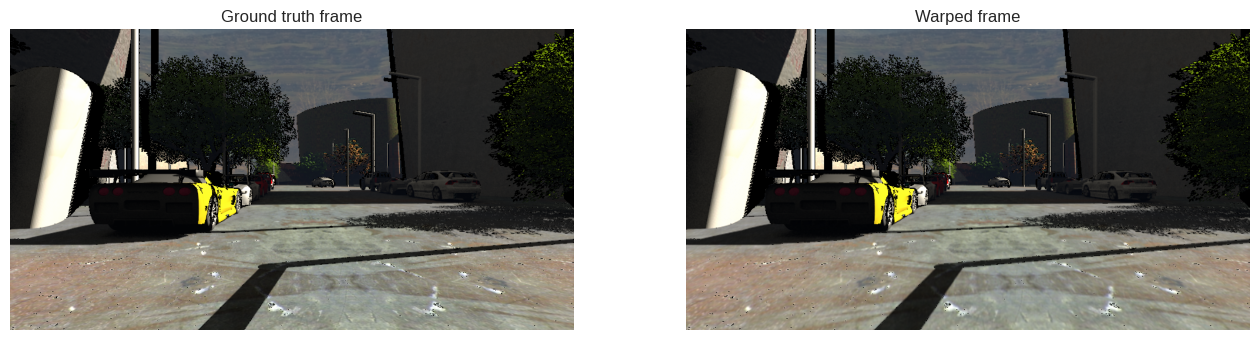

In [51]:
# i = random.randint(1, len(frame_ids) - 1)
i = 89
frame_warp_gt = frames[i:i+1].clone()
frame_warp = warp_flow(frames[i-1:i], past_flows[i:i+1])
_, mask_bwd = compute_fwdbwd_mask(flows[i-1:i], past_flows[i:i+1], alpha=0.1)
mask_bwd &= (frame_warp - frame_warp_gt).abs().max(dim=1).values < 0.1
frame_warp[0, :, ~mask_bwd[0]] = 0
frame_warp_gt[0, :, ~mask_bwd[0]] = 0
frame_warp = frame_warp[0].permute(1, 2, 0).cpu().numpy()
frame_warp_gt = frame_warp_gt[0].permute(1, 2, 0).cpu().numpy()

# x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
# y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
# mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
# frame_warp = torch.zeros_like(frames[i])
# frame_warp[:, y[mask], x[mask]] = frames[i-1, :, grid_y[mask], grid_x[mask]]
# frame_warp = frame_warp.permute(1, 2, 0).cpu().numpy()
# frame_warp_gt = frames[i].permute(1, 2, 0).cpu().numpy()

# frame_warp[:, grid_y[mask], grid_x[mask]] = frames[i-1, :, y[mask], x[mask]]
# frame_warp = frame_warp.permute(1, 2, 0).cpu().numpy()
# frame_warp_gt = frames[i].permute(1, 2, 0).cpu().numpy()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(frame_warp_gt)
plt.title("Ground truth frame")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(frame_warp)
# plt.imshow(~mask_bwd[0].cpu().numpy())
plt.title("Warped frame")
plt.axis("off")

In [52]:
flow_ids = flow_ids.reshape(-1)
feats_rgb = frames.permute(0, 2, 3, 1).reshape(-1, 3)
feats_coord = coords_w.permute(0, 2, 3, 1).reshape(-1, 3)
_, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_t, dim=0, reduce='mean')
feats_coord = torch_scatter.scatter(feats_coord, unq_inv_t, dim=0, reduce='max')
new_frames = feats_rgb[unq_inv_t].reshape(N, H, W, 3).permute(0, 3, 1, 2)
# data_parser.unq_inv = unq_inv_t

# contract to unit sphere
# decide aabb according to density
# feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
# voxel_size = torch.tensor([1e-3] * 3, dtype=feats_coord.dtype, device=feats_coord.device)

# voxel_size = torch.tensor([0.1] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
# xyz_min = torch.min(feats_coord, dim=0).values
# voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
# voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
# voxel_coords = torch.cat([voxel_coords, torch.div(feats_rgb, 2 / 255, rounding_mode='floor')], dim=1)

# feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
# feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')
# print(f"Total number of unique voxels: {feats_rgb.shape[0]} / {N * H * W}")

# unq_inv = unq_inv_xyz[unq_inv_t]
# new_frames = feats_rgb[unq_inv].reshape(N, H, W, 3).permute(0, 3, 1, 2)
# del unq_inv_t, unq_inv_xyz

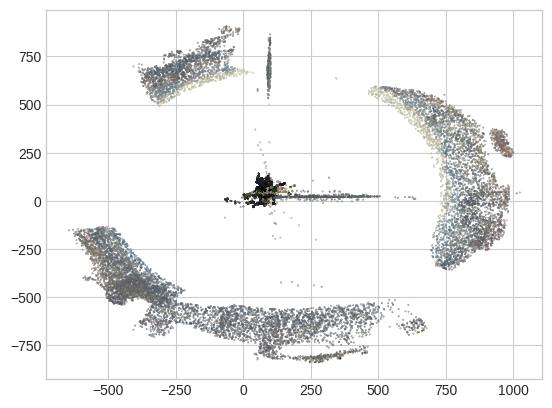

In [29]:
interval = 50
pcd_xyz = feats_coord.cpu().numpy()[::interval]
pcd_rgb = feats_rgb.cpu().numpy()[::interval]
# mask = (pcd_xyz[:, 0] > -100) & (pcd_xyz[:, 0] < 200) & (pcd_xyz[:, 1] > -100) & (pcd_xyz[:, 1] < 200)
# pcd_xyz = pcd_xyz[mask]
# pcd_rgb = pcd_rgb[mask]
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(pcd_xyz[:, 0], pcd_xyz[:, 1], c=pcd_rgb, s=0.1)
# plt.xlim(0, 150)
# plt.ylim(-50, 150)
plt.show()

(-0.5, 959.5, 511.5, -0.5)

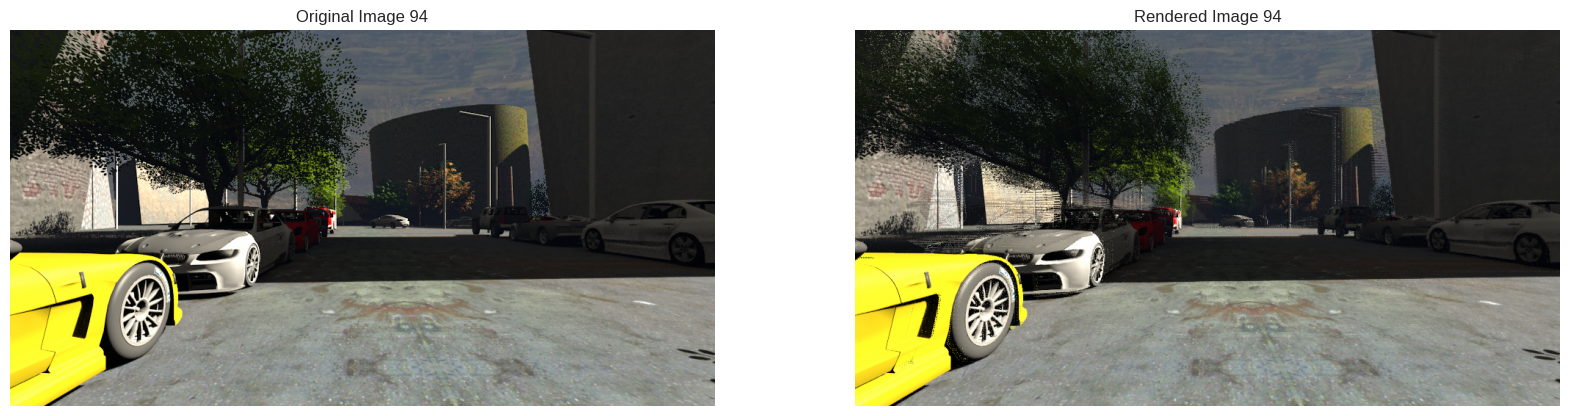

In [65]:
idx = random.randint(0, len(frame_ids) - 1)
# idx = 1
pil_img = frames[idx].cpu().numpy().transpose(1, 2, 0)
rendered_img = new_frames[idx].cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.title(f'Original Image {idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_img)
plt.title(f'Rendered Image {idx}')
plt.axis('off')

## 1. Optimization

In [5]:
from torch import nn
from pytorch_msssim import ssim, ms_ssim
from plugin.VidToMe.utils import save_video
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss
from utils.dataloader import OptDataset

max_sh_degree = 3
lambda_dssim = 0.2
lambda_flow = 0.8
lambda_exp = 0.8
epochs = 70
batch_size = 100
iterations = epochs * len(frame_ids) // batch_size

feature_lr = 0.05 * batch_size / len(frame_ids)
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0

/data1/jing_li/anaconda3/envs/iclight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
pil_list = eu.video_to_pil_list(f'{output_dir}/output_gt.gif')
org_images = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0) / 255.0

mask_bwds = torch.ones_like(org_images[:, 0], dtype=torch.bool)
_, mask_bwds[1:] = compute_fwdbwd_mask(flows[:-1], past_flows[1:])
org_images_warp = warp_flow(org_images[:-1], past_flows[1:])
mask_bwds[1:] &= (org_images_warp - org_images[1:]).abs().max(dim=1).values < org_images.max().item() * 0.1
mask_bwds = mask_bwds[:, None, ...].repeat(1, 3, 1, 1)

pil_list = eu.video_to_pil_list(f'{output_dir}/output.gif')
edited_images = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0) / 255.0
N, _, H, W = edited_images.shape

dataset = OptDataset(
    edited_images, 
    past_flows,
    mask_bwds,
    device=data_parser.device
)

In [7]:
exposure = nn.Parameter(torch.eye(3, 4, device="cuda")[None].repeat(len(frame_ids), 1, 1).requires_grad_(True))
exposure_optimizer = torch.optim.Adam([exposure])
exposure_scheduler_args = get_expon_lr_func(exposure_lr_init, exposure_lr_final,
                                            lr_delay_steps=exposure_lr_delay_steps,
                                            lr_delay_mult=exposure_lr_delay_mult,
                                            max_steps=iterations)

Optimizing Exposures: 100%|██████████| 70/70 [00:26<00:00,  2.63it/s, loss=0.041111, loss_flow=0.041902, loss_photometric=0.037946]


Text(0.5, 1.0, 'Loss curve')

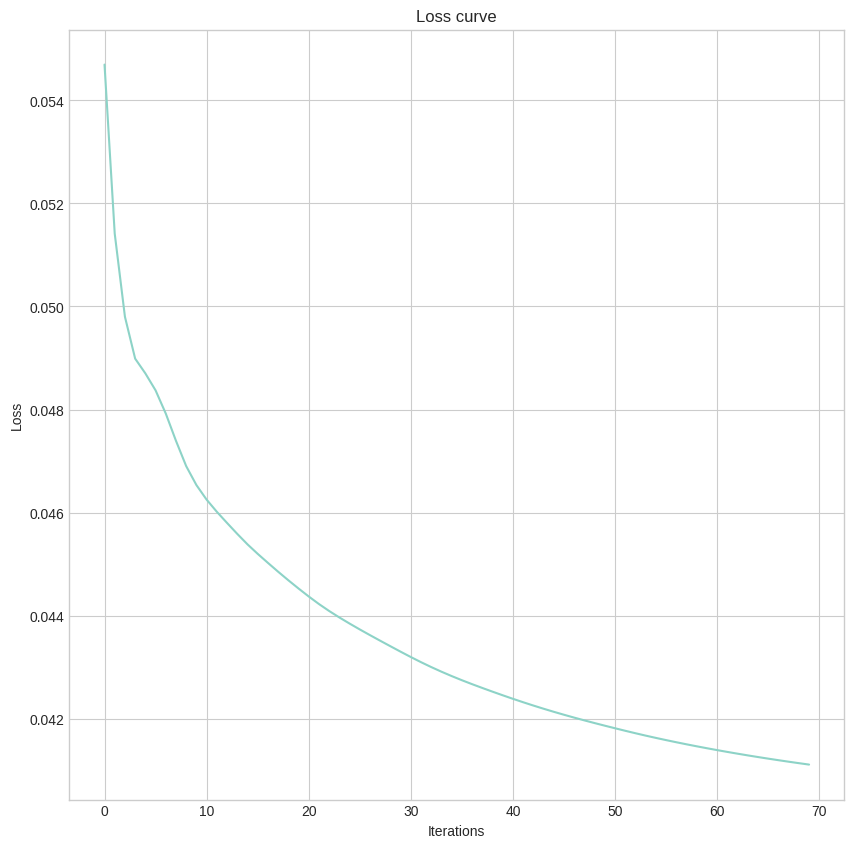

In [8]:
loss_list = []
pbar = tqdm(total=epochs, desc="Optimizing Exposures")

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=len(dataset), 
    shuffle=True
)

for epoch in range(epochs):
    for i, (idxs, _edited_images, _pre_edited_images, _past_flows, _mask_bwds) in enumerate(data_loader):
        iteration = epoch * len(frame_ids) // batch_size + i + 1
        for param_group in exposure_optimizer.param_groups:
            param_group['lr'] = exposure_scheduler_args(iteration)

        cat_images = torch.cat([_edited_images, _pre_edited_images], dim=0)
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        cat_images = torch.bmm(cat_images.permute(0, 2, 3, 1).reshape(-1, H*W, 3), exposure[cat_idxs, :3, :3]) + exposure[cat_idxs, None, :3, 3]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(-1, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        loss_photometric = l1_loss(images, _edited_images)

        warped_images = warp_flow(pre_images, _past_flows)[idxs>0]
        images, _mask_bwds = images[idxs>0], _mask_bwds[idxs>0]

        loss_flow = l1_loss(warped_images[_mask_bwds], images[_mask_bwds])

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list.append(loss.item())

        loss.backward()

        exposure_optimizer.step()
        exposure_optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

dataset.exposure_align(exposure)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve")

In [9]:
with torch.no_grad():
    key_frames_idx = torch.arange(0, len(frame_ids), 4)
    pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='max')
    print(f"Total number of unique voxels: {pil_tensor.shape[0]} / {N * H * W}")

    # xyz = torch_scatter.scatter(coords_w.permute(0, 2, 3, 1).reshape(N*H*W, -1), data_parser.unq_inv, dim=0, reduce='mean')
    # dir_pp = xyz[:, None, :] - c2ws[None, :, :3, 3]
    # del frames, coords_w, c2ws
    # dir_pp = dir_pp / torch.linalg.norm(dir_pp, dim=-1, keepdim=True)

fused_color = RGB2SH(pil_tensor.requires_grad_(True))
features_dc = nn.Parameter(fused_color.contiguous().requires_grad_(True))

# features = torch.zeros((fused_color.shape[0], 3, (max_sh_degree + 1) ** 2)).float().to(fused_color.device)
# features[:, :3, 0 ] = fused_color
# features_dc = nn.Parameter(features[:,:,0:1].transpose(1, 2).contiguous().requires_grad_(True))
# features_rest = nn.Parameter(features[:,:,1:].transpose(1, 2).contiguous().requires_grad_(True))

l = [
    {'params': [features_dc], 'lr': feature_lr, "name": "f_dc"},
    # {'params': [features_rest], 'lr': feature_lr / 20.0, "name": "f_rest"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

Total number of unique voxels: 21167232 / 49152000


Optimizing Unique Tensor: 100%|██████████| 70/70 [01:00<00:00,  1.16it/s, loss=0.007943, loss_flow=0.003572, loss_photometric=0.025427]


Text(0.5, 1.0, 'Loss curve')

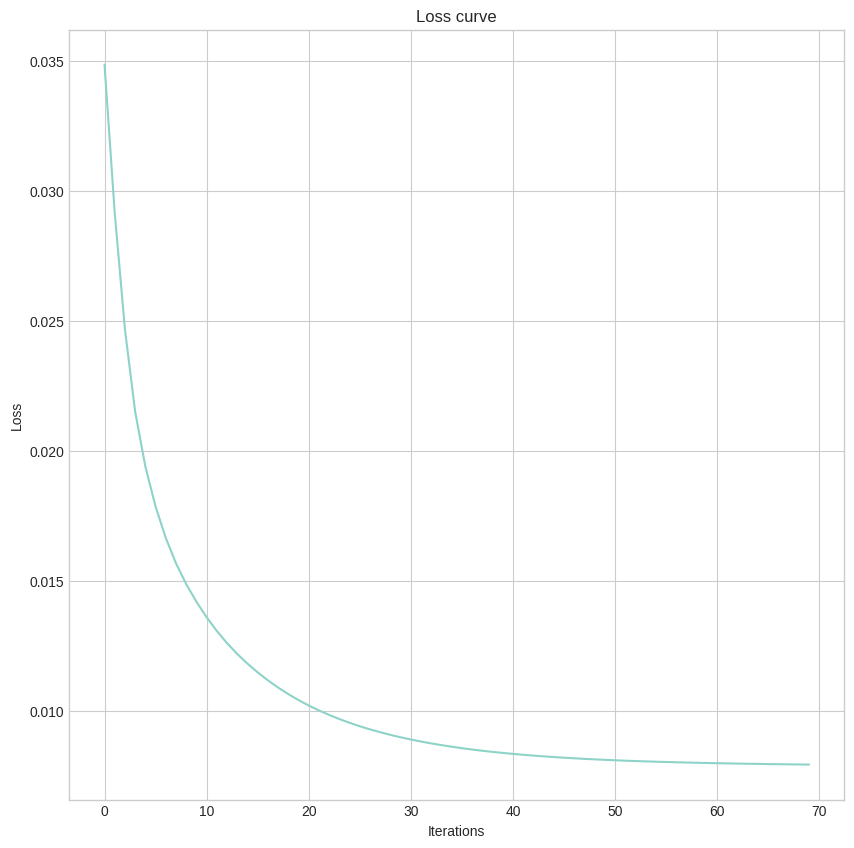

In [10]:
loss_list = []

pbar = tqdm(total=epochs, desc="Optimizing Unique Tensor")
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)
quant_scalor = 8.0 / 255.0

for epoch in range(epochs):
    for i, (idxs, _edited_images, _, _past_flows, _mask_bwds) in enumerate(data_loader):
        # iteration = epoch * len(frame_ids) // batch_size + i + 1
        _mask_bwds = _mask_bwds[idxs>0]
        cat_images = torch.cat([_edited_images, _pre_edited_images], dim=0)
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        unq_inv = data_parser.unq_inv.reshape(N, H, W, -1)[cat_idxs].reshape(-1)
        cat_images = SH2RGB(features_dc)[unq_inv].reshape(len(cat_idxs), H*W, -1) # N x HW x 3
        cat_images = torch.clamp(cat_images, 0, 1).reshape(len(cat_idxs), H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        warped_images = warp_flow(pre_images, _past_flows)
        
        loss_flow = l1_loss(warped_images[idxs>0][_mask_bwds], images[idxs>0][_mask_bwds])
        
        # quantize images to relax the restriction

        loss_photometric  = (1.0 - ms_ssim(images, _edited_images, data_range=1)) * lambda_dssim

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list.append(loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none = True)

    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve")

In [11]:
images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
# images = torch.bmm(images, exposure[:, :3, :3]) + exposure[:, None, :3, 3]
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
save_name = f"opt_lr_{feature_lr}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_ssim_{lambda_dssim}_it{iterations}_loss_{loss_list[-1]:.3f}"
cur_output_path = os.path.join(output_dir, save_name)
save_video(images, cur_output_path, save_frame=True)
# copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

[INFO] save video to ../workdir/sceneflow/sceneflow_highres_test_lmr_0.2_gmr_0.1/opt_lr_0.05_lambda_flow_0.8_lambda_exp_0.8_ssim_0.3_it70_loss_0.008/output.gif


0

In [12]:
# coords_mask = ((coords_w.abs()[:, 0:1] > 50) & (coords_w.abs()[:, 1:2] > 50)).repeat(1, 3, 1, 1)
images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W
# images[coords_mask] = 0

In [13]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
# org_images_np = org_images.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 959.5, 511.5, -0.5)

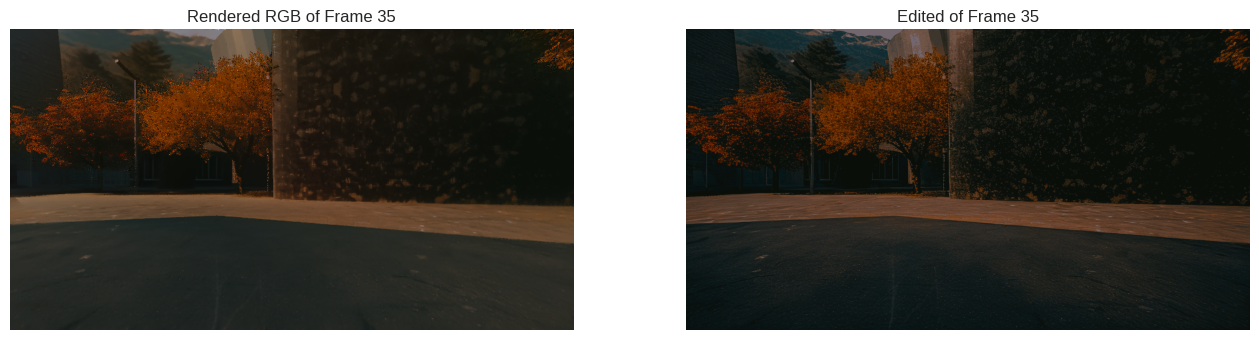

In [14]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
# idx = 80
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
plt.axis("off")